## Open National Speed Limit Registar (NSLR) shapefile

C:\Users\csu55\AppData\Local\anaconda3\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: NSLR/SpeedLimitZoneFull_edit.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Index(['speedLimit', 'speedLim_1', 'rcaZoneRef', 'rcaZoneR_1', 'legalRefer',
       'legalInstr', 'legalIns_1', 'speedManag', 'speedMan_1', 'speedCateg',
       'speedLim_2', 'speedLim_3', 'speedLim_4', 'speedLim_5', 'speedLim_6',
       'speedLim_7', 'speedLim_8', 'speedLim_9', 'speedLi_10', 'speedLi_11',
       'speedLi_12', 'whenEffect', 'whenIneffe', 'GlobalID', 'SeperateLa',
       'speedLi_13', 'speedLi_14', 'geometry'],
      dtype='object')
                             speedLimit                            speedLim_1  \
0  94067d2d-fcad-4bd5-977b-9cd60cff6a47  52dc129e-9f47-49d0-897b-145fa76b60c0   
1  a032ae70-aff1-4386-8583-43f58cd26bd7  96fa6cda-be0f-4235-a4b2-dad473342a5c   
2  57bb527b-751a-4ecc-8979-625c96303d65  58555dab-91a1-4ac0-ac49-3444c00cf397   
3  6f3bcdea-3910-438b-a090-1778df865f63  65aa0dd7-3e2f-4758-8051-28fe075212ce   
4  f0f513d8-4c44-4845-8784-8727e7de4901  c21022f3-c690-4b61-b7ba-325aedcf9dd6   

                             rcaZoneRef                 rcaZ

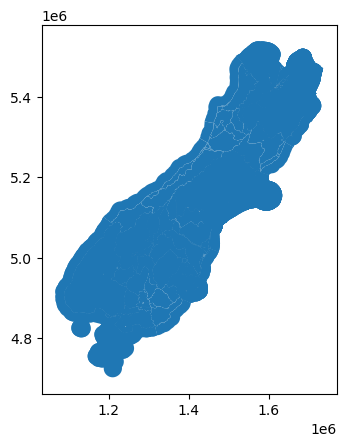

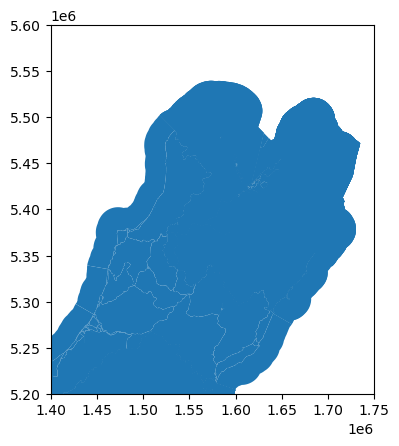

In [153]:
shapefile_path = "NSLR/SpeedLimitZoneFull_edit.shp"

# Read the shapefile
gdf = gpd.read_file(shapefile_path)
gdf.plot()

minx, miny, maxx, maxy = gdf.total_bounds

# Plot the shapefile
gdf.plot()

# Set the limits for the plot
plt.xlim(1400000, 1750000)  # Set the x-axis limits
plt.ylim(5200000, 5600000) 

print(gdf.columns)
print(gdf.head())

In [154]:
print(gdf.iloc[-1])
print(gdf['speedLim_6'].unique())
print(gdf['speedLim_2'].unique())

speedLimit                                                 None
speedLim_1                                                 None
rcaZoneRef                                                 None
rcaZoneR_1                                                 None
legalRefer                                                 None
legalInstr                                                 None
legalIns_1                                                 None
speedManag                                                 None
speedMan_1                                                 None
speedCateg                                            Permanent
speedLim_2                                                  100
speedLim_3                                                 None
speedLim_4                                                 None
speedLim_5                                                 None
speedLim_6                                           Speed Area
speedLim_7                              

In [162]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Define paths
shapefile_path = "NSLR/SpeedLimitZoneFull_edit.shp"
input_folder = "Processed_GPS_data/"
output_folder = "Processed_GPS_data/"

# Load shapefile
speed_limit_gdf = gpd.read_file(shapefile_path)

wgs84 = CRS.from_epsg(4326)  # WGS84 (EPSG:4326)
nztm2000 = CRS.from_epsg(2193)  # NZTM2000 (EPSG:2193)

# Create a Transformer object for converting WGS84 to NZTM2000
transformer = Transformer.from_crs(wgs84, nztm2000, always_xy=True)

# Function to convert WGS84 to NZTM2000 (assuming it's defined elsewhere)
def wgs84_to_nztm2000(lat, lon, df):
    easting, northing = transformer.transform(lon, lat)
    df['north_NZTM'] = northing
    df['east_NZTM'] = easting
    return df

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Process each CSV file in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith('.csv') and filename.startswith('Processed_{lincense_plate}'):
        print(f"Processing file: {filename}")
        
        # Load GPS data
        GPS = pd.read_csv(os.path.join(input_folder, filename))
        gps_df = wgs84_to_nztm2000(GPS['Latitude'], GPS['Longitude'], GPS)

        # Create GeoDataFrame from GPS data
        gps_gdf = gpd.GeoDataFrame(
            gps_df,
            geometry=gps_df.apply(lambda row: Point(row['east_NZTM'], row['north_NZTM']), axis=1),
            crs=speed_limit_gdf.crs
        )

        # Transform CRS if necessary
        if gps_gdf.crs != speed_limit_gdf.crs:
            gps_gdf = gps_gdf.to_crs(speed_limit_gdf.crs)

        # Perform spatial join
        result = gpd.sjoin(gps_gdf, speed_limit_gdf, how="left", predicate="within")

        # Deduplicate results: keep only the first match for each GPS point
        result_right = result[~result.index.duplicated(keep="last")]

        # Select desired columns
        result_right = result_right[['No', 'Deviceid', 'Vehicle', 'Driver', 'Date & Time',
                                     'Road Name', 'Longitude', 'Latitude', 'Elevation (m)', 'Region', 'Geofence ReportID',
                                     'IGN', 'Speed', 'Heading', 'Altitude', 'Satellite', 'Event Name',
                                     'Odometer', 'Hourmeter', 'Fuel Level', 'Fuel Realtime', 'Fuel Litre',
                                     'Fuel Rt Litre', 'Input', 'Output', 'Analog1', 'Analog 2',
                                     'Distance (m)', 'Fuel Consumption', 'Duration', 'Average Speed', 
                                     'north_NZTM', 'east_NZTM', 'geometry', 'speedLim_2', 'speedLim_6']]

        # Save the processed data to a new CSV file
        output_filename = os.path.join(output_folder, f"Processed_2_{filename}")
        result_right.to_csv(output_filename, index=False)
        print(f"Saved processed file: {output_filename}")

print("All files processed.")

C:\Users\csu55\AppData\Local\anaconda3\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: NSLR/SpeedLimitZoneFull_edit.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Processing file: Processed_LWY799_GPS_data.csv
Saved processed file: Processed_GPS_data/Processed_2_Processed_LWY799_GPS_data.csv
All files processed.


In [144]:
#print(result[result_right['speedLim_2'].isna()])
speed_lim_100 = result_right[(result_right['speedLim_2'] == '100') & (result_right['speedLim_6'] != 'Default Area')].copy()
print(len(speed_lim_100))
speed_lim_90 = result_right[result_right['speedLim_2']=='90'].copy()
print(len(speed_lim_90))
speed_lim_80  = result_right[result_right['speedLim_2']=='80'].copy()
print(len(speed_lim_80))
speed_lim_70 = result_right[result_right['speedLim_2']=='70'].copy()
print(len(speed_lim_70))
speed_lim_60 = result_right[result_right['speedLim_2']=='60'].copy()
print(len(speed_lim_60))
speed_lim_50 = result_right[(result_right['speedLim_2']=='50') & (result_right['speedLim_6'] != 'Urban Traffic Area')].copy()
print(len(speed_lim_50))
speed_lim_40 = result_right[result_right['speedLim_2']=='40'].copy()
print(len(speed_lim_40))
speed_lim_30 = result_right[result_right['speedLim_2']=='30'].copy()
print(len(speed_lim_30))
speed_lim_20 = result_right[result_right['speedLim_2']=='20'].copy()
print(len(speed_lim_20))
speed_lim_nan = result_right[result_right['speedLim_2'].isna()].copy()
print(len(speed_lim_nan))
#result_right.to_csv(f'File_path.csv')

0
0
0
0
0
0
0
0
0
0


OSError: Cannot save file into a non-existent directory: 'LWY799'

In [46]:
print(result_right['speedLim_6'].unique())
print(result_right['speedLim_2'].unique())

print(speed_lim_80['speedLim_6'].unique())
print(speed_lim_80['speedLim_2'].unique())

print(speed_lim_90['speedLim_6'].unique())
print(speed_lim_90['speedLim_2'].unique())

print(speed_lim_100['speedLim_6'].unique())
print(speed_lim_100['speedLim_2'].unique())
#result_right.to_csv(f'File_path_NSLR.csv')
speed_lim_80.to_csv(f'Speed_limit_80.csv')
speed_lim_90.to_csv(f'Speed_limit_90.csv')

['Urban Traffic Area' 'Speed Area' 'Default Area'
 'The presence of a school' 'CBD' 'Car Park' nan 'Reserves']
['50' '80' '100' '70' '60' '30' '90' '20' nan '40']
['Speed Area' 'The presence of a school']
['80']
['Speed Area' 'The presence of a school']
['90']
['Speed Area']
['100']


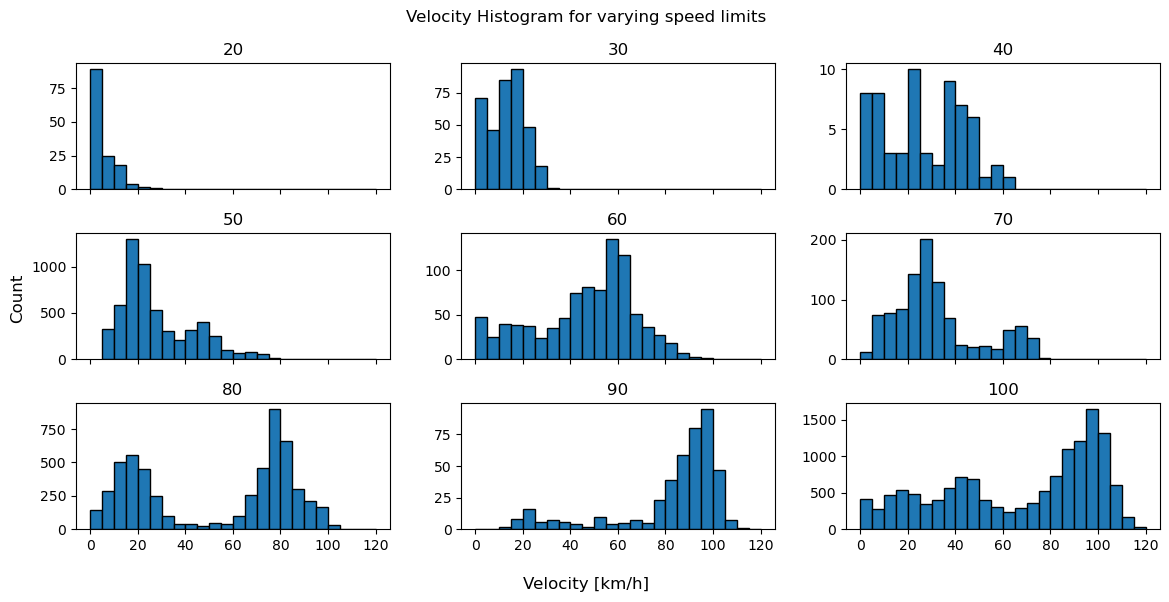

In [50]:
fig,ax = plt.subplots(3,3,figsize=(12,6), sharex=True)#, sharey=True)
plt.suptitle(f'Velocity Histogram for varying speed limits')
fig.supxlabel(f'Velocity [km/h]')
fig.supylabel(f'Count')

ax[0,0].hist(speed_lim_20['Speed'],bins=range(0, 125, 5), edgecolor='black')
ax[0,0].set_title(f'20')

ax[0,1].hist(speed_lim_30['Speed'],bins=range(0, 125, 5), edgecolor='black')
ax[0,1].set_title(f'30')

ax[0,2].hist(speed_lim_40['Speed'],bins=range(0, 125, 5), edgecolor='black')
ax[0,2].set_title(f'40')

ax[1,0].hist(speed_lim_50['Speed'],bins=range(5, 125, 5), edgecolor='black')
ax[1,0].set_title(f'50')

ax[1,1].hist(speed_lim_60['Speed'],bins=range(0, 125, 5), edgecolor='black')
ax[1,1].set_title(f'60')

ax[1,2].hist(speed_lim_70['Speed'],bins=range(0, 125, 5), edgecolor='black')
ax[1,2].set_title(f'70')

ax[2,0].hist(speed_lim_80['Speed'],bins=range(0, 125, 5), edgecolor='black')
ax[2,0].set_title(f'80')

ax[2,1].hist(speed_lim_90['Speed'],bins=range(0, 125, 5), edgecolor='black')
ax[2,1].set_title(f'90')

ax[2,2].hist(speed_lim_100['Speed'], bins=range(0, 125, 5), edgecolor='black')
ax[2,2].set_title(f'100')

plt.tight_layout()
#fig.savefig(f'{License_plate}_velocity_histogram.png')

# Find velocity to match observed results

In [1]:
import numpy as np

def find_threshold_speed(speeds, original_speed_limit, new_speed_limit):
    """
    Finds the speed threshold such that scaling speeds above it by the scale_factor
    results in a target increase in the mean velocity.
   
    Parameters:
        speeds (array-like): Array of speed values (km/h).
        target_mean_increase (float): Desired increase in mean velocity (km/h).
        scale_factor (float): Scaling factor for speeds above the threshold.
   
    Returns:
        float: The threshold speed.
    """
    # Scale factor based on the speed limits
    scale_factor = new_speed_limit / original_speed_limit
    
    # Target mean change based on 40% of the difference between speed limits
    target_mean_change = 0.4 * (new_speed_limit - original_speed_limit)
    
    # Calculate the original mean speed
    speeds = np.array(speeds)
    original_mean = np.mean(speeds)
    
    # Calculate the desired mean
    desired_mean = original_mean + target_mean_change
    print(f"Original Mean: {original_mean:.2f}, Target Mean: {desired_mean:.2f}, Target Change: {target_mean_change:.2f}")
   
    # Initial threshold value
    threshold = 65.0
    prev_threshold = -1  # Start with a value different from the initial threshold
   
    # Precision tolerance for the result
    tolerance = 1e-6
   
    # Loop until the desired mean is found
    while True:
        # Apply smoothing and scaling to velocities above the threshold
        smoothed_speeds = np.array([smooth_transition(v, threshold, scale_factor) if v > threshold else v for v in speeds])
        
        # Calculate the mean of the adjusted (smoothed) speeds
        adjusted_mean = np.mean(smoothed_speeds)
        
        # Check if the adjusted mean is within the tolerance of the target mean
        if abs(adjusted_mean - desired_mean) <= tolerance:
            break
        
        # Check if adjusted mean has crossed the desired mean
        if prev_threshold != -1:  # Skip the first iteration where there's no previous threshold
            prev_adjusted_mean = np.mean(np.array([smooth_transition(v, prev_threshold, scale_factor) if v > prev_threshold else v for v in speeds]))
            
            # Check if the adjusted mean has crossed the desired mean between two consecutive thresholds
            if (adjusted_mean - desired_mean) * (prev_adjusted_mean - desired_mean) < 0:
                break
        
        # Store the current threshold as previous threshold for next iteration
        prev_threshold = threshold
        
        # Increase the threshold by 1 for the next iteration
        if threshold > 200:
            print(f"This did not work, try again")
            break
            
        threshold += 0.01
   
    # Return the final threshold speed
    return threshold

In [3]:
def smooth_transition(velocity, threshold, scale, width=5):
    """
    Apply a smooth transition to the velocity based on a threshold and scaling factor.
    The sigmoid function is used for smooth adjustment.
    """
    weight = 1 / (1 + np.exp(-(velocity - threshold) / width))  # Sigmoid function for smooth transition
    rescaled_velocity = scale * velocity
    return (1 - weight) * velocity + weight * rescaled_velocity

In [5]:
def merge_csvs(plate_number):
    folder_path = f"Vehicle_data/{plate_number}"
        
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The directory {folder_path} does not exist.")

    merged_data = pd.DataFrame()  # Empty DataFrame to store merged data
    required_columns = ['speedLim_2', 'speedLim_6', 'velocity (km/h)', 'IGN']

    for file in os.listdir(folder_path):
        #print(f"Processing file: {file}")
        if file.endswith('.csv') and not file.startswith('N') and not file.startswith('Smoothing'):  # Exclude files starting with 'N'
            file_path = os.path.join(folder_path, file)
            try:
                # Read only the required columns
                df = pd.read_csv(file_path, usecols=required_columns)
                #print(f"DataFrame from {file} has {df.shape[0]} rows and {df.shape[1]} columns.")
                # Append to the merged DataFrame
                merged_data = pd.concat([merged_data, df], ignore_index=True)
            except ValueError as ve:
                print(f"Missing required columns in {file}. Skipping. Error: {ve}")
            except Exception as e:
                print(f"Error reading {file}: {e}")

    #print(f"Merged DataFrame has {merged_data.shape[0]} rows and {merged_data.shape[1]} columns.")
    return merged_data

In [7]:
def speed_change_model(model, dataframe, value_80_smo, value_90_smo, value_100_smo):
    GPS = dataframe 
    
    if model == 0:
        filename_string = 'No_Speed_Changes'
    
    if model == 1:
        filename_string = '80_90_to_100'
        #Change speed limits from 80 and 90 to 100
        GPS.loc[(GPS['speedLim_2'] == 80), 'velocity (km/h)'] = GPS.loc[(GPS['speedLim_2'] == 80), 'velocity (km/h)'].apply(lambda v: smooth_transition(v, value_80_smo, 10/8))
        GPS.loc[(GPS['speedLim_2'] == 90), 'velocity (km/h)'] = GPS.loc[(GPS['speedLim_2'] == 90), 'velocity (km/h)'].apply(lambda v: smooth_transition(v, value_90_smo, 10/9))
        
    if model == 2:
        filename_string = '90_100_to_80'
        #Change speed limits from 90 and 100 to 80
        GPS.loc[(GPS['speedLim_2'] == 100) & (GPS['speedLim_6'] != 'Default Area'), 'velocity (km/h)'] = GPS.loc[(GPS['speedLim_2'] == 100) & (GPS['speedLim_6'] != 'Default Area'), 'velocity (km/h)'].apply(lambda v: smooth_transition(v, value_100_smo, 8/10))
        GPS.loc[(GPS['speedLim_2'] == 90), 'velocity (km/h)'] = GPS.loc[(GPS['speedLim_2'] == 90), 'velocity (km/h)'].apply(lambda v: smooth_transition(v, value_90_smo, 8/9))

    
    if model == 3:
        filename_string = '80_100_to_90'
        #Change speed limits from 80 and 100 to 90
        GPS.loc[(GPS['speedLim_2'] == 100) & (GPS['speedLim_6'] != 'Default Area'), 'velocity (km/h)'] = GPS.loc[(GPS['speedLim_2'] == 100) & (GPS['speedLim_6'] != 'Default Area'), 'velocity (km/h)'].apply(lambda v: smooth_transition(v, value_100_smo, 9/10))
        GPS.loc[(GPS['speedLim_2'] == 80), 'velocity (km/h)'] = GPS.loc[(GPS['speedLim_2'] == 80), 'velocity (km/h)'].apply(lambda v: smooth_transition(v, value_80_smo, 9/8))
        
    if model == 4:
        filename_string = '100_to_90'
        #Change speed limits from 100 to 90
        GPS.loc[(GPS['speedLim_2'] == 100) & (GPS['speedLim_6'] != 'Default Area'), 'velocity (km/h)'] = GPS.loc[(GPS['speedLim_2'] == 100) & (GPS['speedLim_6'] != 'Default Area'), 'velocity (km/h)'].apply(lambda v: smooth_transition(v, value_100_smo, 9/10))
        
    if model == 5:
        filename_string = '100_to_110'
        #Change speed limits from 100 to 110
        GPS.loc[(GPS['speedLim_2'] == 100) & (GPS['speedLim_6'] != 'Default Area'), 'velocity (km/h)'] = GPS.loc[(GPS['speedLim_2'] == 100) & (GPS['speedLim_6'] != 'Default Area'), 'velocity (km/h)'].apply(lambda v: smooth_transition(v, value_100_smo, 11/10))

    if model == 6:
        filename_string = '100_to_160'
        #Change speed limits from 100 to 110
        GPS.loc[(GPS['speedLim_2'] == 100) & (GPS['speedLim_6'] != 'Default Area'), 'velocity (km/h)'] = GPS.loc[(GPS['speedLim_2'] == 100) & (GPS['speedLim_6'] != 'Default Area'), 'velocity (km/h)'].apply(lambda v: smooth_transition(v, value_100_smo, 16/10))
    
    return GPS, filename_string

In [9]:
# Vehicle stats loaded here

In [21]:
import os
import pandas as pd
import numpy as np
from scipy.stats import kurtosis

# Function to calculate the coefficient of variation
def coefficient_of_variation(speeds):
    mean_speed = np.mean(speeds)
    std_dev = np.std(speeds)
    return std_dev / mean_speed if mean_speed != 0 else np.nan

# Function to append statistics to CSV
def append_to_csv(data, csv_file):
    if not os.path.exists(csv_file):
        data.to_csv(csv_file, index=False)
    else:
        data.to_csv(csv_file, mode='a', header=False, index=False)

# List of models to apply
models = [1,2,3,4,5,6]  # Replace with actual model names

# Initialize statistics storage
statistics = []

# Loop through each speed limit, vehicle, and model
plates = {]#List of license plates here
license_plates = list(vehicles.keys())

for plate in license_plates:
    vehicle = vehicles[plate]
    value_80_smo = vehicle['80_thres_smo']
    value_90_smo = vehicle['90_thres_smo']
    value_100_smo = vehicle['100_thres_smo']
    new_speed_limit = 110
    
    try:
        # Merge the CSV data for the vehicle
        result_right = merge_csvs(plate)
    except NotImplementedError as e:
        print(e)
        continue  # Skip iteration if merge_csvs is missing
    result_right = merge_csvs(plate)
    #speed_lim = result_right[result_right['IGN']=='ON'].copy()
    #speed_lim = speed_lim[(speed_lim['speedLim_2'] == '100') & (speed_lim['speedLim_6'] != 'Default Area')].copy()
    speed_lim = result_right[(result_right['IGN'] == 'ON') & 
                         (result_right['speedLim_2'] == 100) & 
                         (result_right['speedLim_6'] != 'Default Area')].copy()

    
    if 'velocity (km/h)' not in speed_lim.columns:
        print(f"Skipping {plate}: 'velocity (km/h)' column missing.")
        continue

    # Clean data
    speed_lim = speed_lim[speed_lim['velocity (km/h)'].notna()]
    speed_lim = speed_lim[~speed_lim['velocity (km/h)'].isin([np.inf, -np.inf])]

    # Store original stats before model changes
    if len(speed_lim['velocity (km/h)']) > 0:
        speed_data = np.array(speed_lim['velocity (km/h)'])
        original_speed_data = np.array(speed_lim['velocity (km/h)'])
        original_speed_data2 = speed_lim.copy()
        try:
            apple = 1
            #threshold_speed = threshold_speed = vehicle[f'{original_speed_limit}_thres_smo']
        except NotImplementedError as e:
            print(e)
            continue

        statistics.append({
            'Plate': plate,
            'SL_change': "No_Change",
            'V_15': np.percentile(speed_data, 15),
            'V_50': np.mean(speed_data),
            'V_85': np.percentile(speed_data, 85),
            'stn_dev': np.std(speed_data),
            'CV': coefficient_of_variation(speed_data),
            'kurtosis': kurtosis(speed_data)
        })
    else:
        statistics.append({
            'Plate': plate,
            'SL_change': "No_Change",
            'V_15': 9999,
            'V_50': 9999,
            'V_85': 9999,
            'stn_dev': 9999,
            'coefficient_of_variation': 9999,
            'kurtosis': 9999
        })

    # Apply different models and store statistics
    for model in models:
        original_speed_data2 = speed_lim.copy()
        print(model, plate)
        try:
            modified_speed_lim, model_string = speed_change_model(model, original_speed_data2, value_80_smo, value_90_smo, value_100_smo)
            modified_speed_data = np.array(modified_speed_lim['velocity (km/h)'])
        except NotImplementedError as e:
            print(e)
            continue

        if len(original_speed_data2) > 0:
            speed_data = np.array(speed_lim['velocity (km/h)'])
            try:
                apple = 1
                #threshold_speed = vehicle[f'{original_speed_limit}_thres_smo']
            except NotImplementedError as e:
                print(e)
                continue

            statistics.append({
                'Plate': plate,
                'SL_change': model_string,
                'V_15': np.percentile(modified_speed_data, 15),
                'V_50': np.mean(modified_speed_data),
                'V_85': np.percentile(modified_speed_data, 85),
                'stn_dev': np.std(modified_speed_data),
                'CV': coefficient_of_variation(modified_speed_data),
                'kurtosis': kurtosis(modified_speed_data)
            })
        else:
            statistics.append({
                'Plate': plate,
                'SL_change': model_string,
                'V_15': 9999,
                'V_50': 9999,
                'V_85': 9999,
                'stn_dev': 9999,
                'CV': 9999,
                'kurtosis': 9999
            })

# Convert to DataFrame
statistics_df = pd.DataFrame(statistics)
columns = ['Plate', 'SL_change', 'V_15', 'V_50', 'V_85', 'stn_dev', 'CV', 'kurtosis']
statistics_df = statistics_df[columns] 

# Save to CSV
csv_file = 'vehicle_speed_statistics_all_models_only_100kmh.csv'
append_to_csv(statistics_df, csv_file)

print(f"Statistics have been appended to {csv_file}")

1 MHG998
2 MHG998
3 MHG998
4 MHG998
5 MHG998
6 MHG998
1 JSJ858
2 JSJ858
3 JSJ858
4 JSJ858
5 JSJ858
6 JSJ858
1 LDG161
2 LDG161
3 LDG161
4 LDG161
5 LDG161
6 LDG161
1 DLZ695
2 DLZ695
3 DLZ695
4 DLZ695
5 DLZ695
6 DLZ695
1 HLW912
2 HLW912
3 HLW912
4 HLW912
5 HLW912
6 HLW912
1 HQW812
2 HQW812
3 HQW812
4 HQW812
5 HQW812
6 HQW812
1 JRK947
2 JRK947
3 JRK947
4 JRK947
5 JRK947
6 JRK947
1 KMR237
2 KMR237
3 KMR237
4 KMR237
5 KMR237
6 KMR237
1 KSU878
2 KSU878
3 KSU878
4 KSU878
5 KSU878
6 KSU878
1 MGC95
2 MGC95
3 MGC95
4 MGC95
5 MGC95
6 MGC95
1 MCF324
2 MCF324
3 MCF324
4 MCF324
5 MCF324
6 MCF324
1 JZD724
2 JZD724
3 JZD724
4 JZD724
5 JZD724
6 JZD724
1 LWY799
2 LWY799
3 LWY799
4 LWY799
5 LWY799
6 LWY799
Statistics have been appended to vehicle_speed_statistics_all_models_only_100kmh.csv


In [2]:
#print(speed_data)
import numpy as np
import matplotlib.pyplot as plt
import os
# Step 1: Sort the speed data

plate_number = #''
result_right = merge_csvs(plate_number)

if original_speed_limit==100:
    speed_lim = result_right[(result_right['speedLim_6'] != 'Default Area')].copy()
    speed_lim = speed_lim[speed_lim['velocity (km/h)'].notna()]
    speed_lim = speed_lim[~speed_lim['velocity (km/h)'].isin([np.inf, -np.inf])]

if original_speed_limit==90:
    speed_lim = result_right[result_right['speedLim_2']==original_speed_limit].copy()
    speed_lim = speed_lim[speed_lim['velocity (km/h)'].notna()]
    speed_lim = speed_lim[~speed_lim['velocity (km/h)'].isin([np.inf, -np.inf])]

if original_speed_limit==80:
    speed_lim  = result_right[result_right['speedLim_2']==original_speed_limit].copy()
    speed_lim = speed_lim[speed_lim['velocity (km/h)'].notna()]
    speed_lim = speed_lim[~speed_lim['velocity (km/h)'].isin([np.inf, -np.inf])]


sorted_speeds = np.sort(speed_data)

# Step 2: Compute the cumulative frequency (using np.arange for the number of data points)
cumulative_frequency = np.arange(1, len(sorted_speeds) + 1) / len(sorted_speeds)

# Step 3: Plot the cumulative frequency
plt.figure(figsize=(8, 6))
plt.plot(sorted_speeds, cumulative_frequency, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Speed (km/h)')
plt.ylabel('Cumulative Frequency')
plt.title(f'Cumulative Frequency Plot of {plate_number} Speed Data')

# Display the plot
plt.grid(True)
plt.show()

SyntaxError: invalid syntax (2858021843.py, line 7)

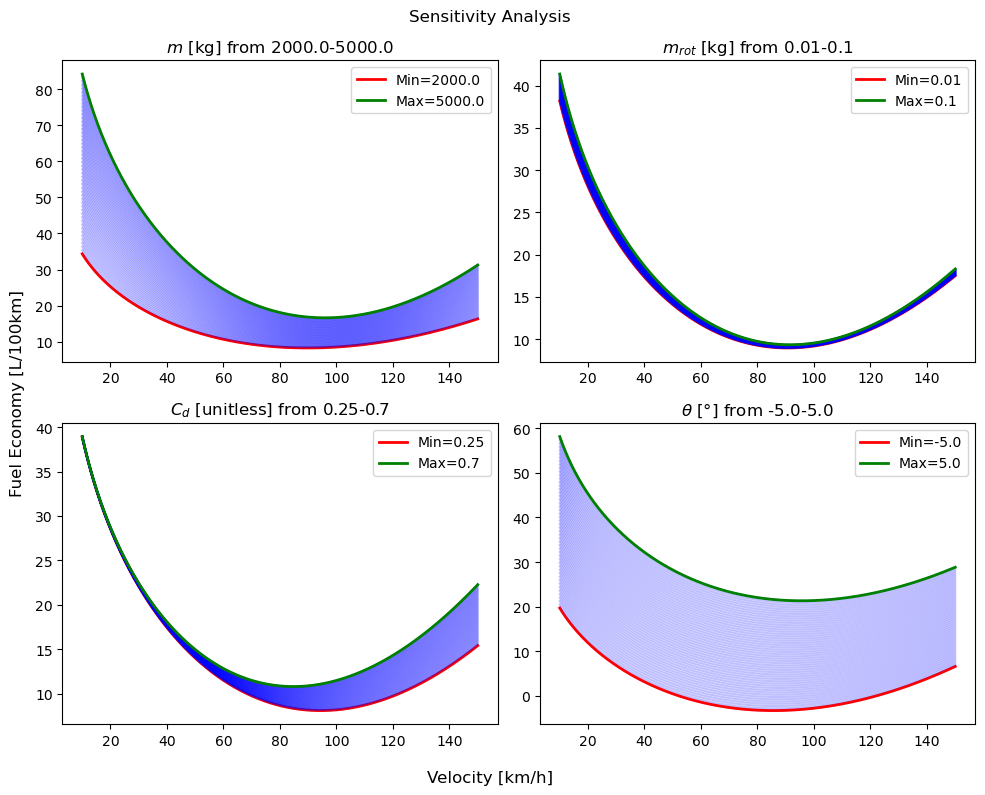

In [143]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
v_range = np.linspace(10, 150, 1400)  # Velocity range from 0 to 40 m/s
m = 2075+200  # kg (mass)
m_rot = 0.03*m  # kg (rotational mass)
Cd = 0.40  # drag coefficient
theta = 0  # degrees (angle)
a, b, c = 1.88, -0.032, 0.00016  # parameters for `bea`
d, e = 481.7, 0.202  # parameters for `be`

# Function to calculate `FE`
def calculate_FE(m, m_rot, Cd, theta, a, b, c, d, e, v):
    bea = a + b*v + c*v**2
    be = d*v**(-e)
    FE = (1/(3600*10*0.85)) * ((1.225*Cd*2.506/2)*(v/3.6)**2 + m*9.81*(0.01+0.000225*(v/3.6)) + m*9.81*np.sin(np.radians(theta)) + (m+m_rot)*bea) * be
    return FE

# Set up the figure for subplots (3x3 grid)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))#, sharex=True, sharey=True)
axes = axes.flatten()
plt.suptitle(f'Sensitivity Analysis')
fig.supxlabel(f'Velocity [km/h]')
fig.supylabel(f'Fuel Economy [L/100km]')

# List of variable names and ranges to test
variables = ['m', 'm_{rot}', 'C_{d}', 'θ']
variable_ranges = {
    'm': np.linspace(2000, 5000, 50),
    'm_{rot}': np.linspace(0.01, 0.1, 50),
    'C_{d}': np.linspace(0.25, 0.7, 50),
    'θ': np.linspace(-5, 5, 50),
}

# Loop through each variable and generate plots
for i, var in enumerate(variables):
    ax = axes[i]
    range_values = variable_ranges[var]
    maxi = max(range_values)
    mini = min(range_values)
    
    # Plot FE vs velocity for different values of the current variable
    for val in range_values:
        if var == 'm':
            FE_values = [calculate_FE(val, m_rot, Cd, theta, a, b, c, d, e, v) for v in v_range]
            units = '[kg]'
        elif var == 'm_{rot}':
            FE_values = [calculate_FE(m, val*m, Cd, theta, a, b, c, d, e, v) for v in v_range]
            units = '[kg]'
        elif var == 'C_{d}':
            FE_values = [calculate_FE(m, m_rot, val, theta, a, b, c, d, e, v) for v in v_range]
            units = '[unitless]'
        elif var == 'θ':
            FE_values = [calculate_FE(m, m_rot, Cd, val, a, b, c, d, e, v) for v in v_range]
            units = '[°]'
        # Plot the results for this variable
        ax.plot(v_range, FE_values, color='blue', alpha=0.25)
        if val == maxi:
            ax.plot(v_range, FE_values, label=f'Max={maxi}', color='green', linewidth=2)

        if val == mini:
            ax.plot(v_range, FE_values, label=f'Min={mini}', color='red', linewidth=2)
             
    #ax.set_xlabel('Velocity (m/s)')
    #ax.set_ylabel('Fuel Economy (FE)')
    ax.set_title(f'${var}$ {units} from {min(range_values)}-{max(range_values)}')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()
fig.savefig(f'Sensitivity_Analysis_relevant_variables.png')